In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.requests import CryptoLatestQuoteRequest
from alpaca.data.requests import CryptoTradesRequest
from alpaca.data.timeframe import TimeFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from numpy.lib import math

%matplotlib inline

In [32]:
load_dotenv()

True

In [33]:
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [34]:
crypto_client = CryptoHistoricalDataClient()

In [35]:
request_params = CryptoBarsRequest(
    symbol_or_symbols=["ETH/USD"],
    timeframe=TimeFrame.Hour, start='2021-09-30 00:00:00'
)

eth_bars = crypto_client.get_crypto_bars(request_params)

eth_df = eth_bars.df

eth_df

open    high     low   close    volume  \
symbol  timestamp                                                             
ETH/USD 2021-09-30 00:00:00+00:00  2849.8  2934.8  2838.3  2934.2   706.304   
        2021-09-30 01:00:00+00:00  2935.8  2985.4  2918.2  2961.0   760.251   
        2021-09-30 02:00:00+00:00  2965.4  2994.4  2961.1  2990.6  3886.627   
        2021-09-30 03:00:00+00:00  2992.0  3035.8  2970.0  3029.0  5551.980   
        2021-09-30 04:00:00+00:00  3030.3  3049.2  3014.0  3017.1   401.627   
...                                   ...     ...     ...     ...       ...   
        2022-10-02 22:00:00+00:00  1300.5  1305.3  1287.0  1289.9  1756.873   
        2022-10-02 23:00:00+00:00  1289.9  1291.2  1269.2  1276.8  1812.680   
        2022-10-03 00:00:00+00:00  1276.9  1284.9  1263.4  1282.1  2902.308   
        2022-10-03 01:00:00+00:00  1282.1  1299.4  1281.8  1298.0  1795.191   
        2022-10-03 02:00:00+00:00  1298.0  1300.4  1292.1  1292.1   636.847   

                                   trade_count         vwap  
symbol  timestamp                                            
ETH/USD 2021-09-30 00:00:00+00:00        393.0  2887.453790  
        2021-09-30 01:00:00+00:00        352.0  2957.585712  
        2021-09-30 02:00:00+00:00        573.0  2975.692584  
        2021-09-30 03:00:00+00:00        669.0  2991.111283  
        2021-09-30 04:00:00+00:00        115.0  3030.674760  
...                                        ...          ...  
        2022-10-02 22:00:00+00:00       1739.0  1295.754547  
        2022-10-02 23:00:00+00:00       1999.0  1278.406289  
        2022-10-03 00:00:00+00:00       1990.0  1275.835152  
        2022-10-03 01:00:00+00:00       1318.0  1293.015434  
        2022-10-03 02:00:00+00:00        429.0  1296.922192  

[8817 rows x 7 columns]

In [36]:
eth_df = eth_df.reset_index()
eth_df = eth_df.set_index('timestamp')
eth_df = eth_df.drop(columns=['symbol'])

eth_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2021-09-30 00:00:00+00:00,2849.8,2934.8,2838.3,2934.2,706.304,393.0,2887.453790
2021-09-30 01:00:00+00:00,2935.8,2985.4,2918.2,2961.0,760.251,352.0,2957.585712
2021-09-30 02:00:00+00:00,2965.4,2994.4,2961.1,2990.6,3886.627,573.0,2975.692584
2021-09-30 03:00:00+00:00,2992.0,3035.8,2970.0,3029.0,5551.980,669.0,2991.111283
2021-09-30 04:00:00+00:00,3030.3,3049.2,3014.0,3017.1,401.627,115.0,3030.674760
...,...,...,...,...,...,...,...
2022-10-02 22:00:00+00:00,1300.5,1305.3,1287.0,1289.9,1756.873,1739.0,1295.754547
2022-10-02 23:00:00+00:00,1289.9,1291.2,1269.2,1276.8,1812.680,1999.0,1278.406289
2022-10-03 00:00:00+00:00,1276.9,1284.9,1263.4,1282.1,2902.308,1990.0,1275.835152


In [37]:
# Use the pct_change function to generate  returns from close prices
eth_df["Actual Returns"] = eth_df["close"].pct_change()

# Drop na
eth_df=eth_df.dropna()

In [38]:
# Store the target variable into 'Signal' column
# if the next day close is greater than the previous day close 'Signal' = 1,
# Otherwise 'Signal' = 0
eth_df['Signal'] = np.where(eth_df['close'].shift(-1) >= eth_df['close'], 1, 0)

eth_df.head()

C:\Users\potte\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,open,high,low,close,volume,trade_count,vwap,Actual Returns,Signal
timestamp,,,,,,,,,
2021-09-30 01:00:00+00:00,2935.8,2985.4,2918.2,2961.0,760.251,352.0,2957.585712,0.009134,1
2021-09-30 02:00:00+00:00,2965.4,2994.4,2961.1,2990.6,3886.627,573.0,2975.692584,0.009997,1
2021-09-30 03:00:00+00:00,2992.0,3035.8,2970.0,3029.0,5551.980,669.0,2991.111283,0.012840,0
2021-09-30 04:00:00+00:00,3030.3,3049.2,3014.0,3017.1,401.627,115.0,3030.674760,-0.003929,1
2021-09-30 05:00:00+00:00,3023.0,3041.3,3019.5,3029.7,141.883,108.0,3025.002656,0.004176,0


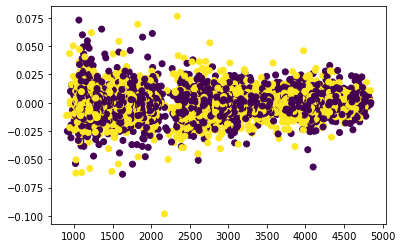

In [39]:
# Plot the data
plt.scatter(
    # Put the user download date along the x-axis
    x = eth_df['close'],
    # Put the user download location along the y-axis
    y = eth_df['Actual Returns'],
    # Plot the binary y variable (whether the user made a transaction) as the color
    c=eth_df['Signal']
 )

# Show the plot
plt.show()

In [40]:
# Import the module
from sklearn.model_selection import train_test_split

# Separate the y variable, the labels
y = eth_df['Signal']

# Separate the X variable, the features
X = eth_df.drop(columns=['Signal'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [41]:
# Count the distinct values
y_train.value_counts()

1    3334
0    3278
Name: Signal, dtype: int64

In [42]:
# Import the module
from imblearn.over_sampling import RandomOverSampler

# Resample the data
random_oversampler = RandomOverSampler(random_state=1)
X_resampled, y_resampled = random_oversampler.fit_resample(X_train, y_train)

In [43]:
# Count the distinct values
y_resampled.value_counts()

1    3334
0    3334
Name: Signal, dtype: int64

In [44]:
# Import the module
from sklearn.linear_model import LogisticRegression

# Declare a logistic regression model
model = LogisticRegression(random_state=1)

# Fit the model
model.fit(X_resampled, y_resampled)

C:\Users\potte\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=1)

In [45]:
# Import the module
from sklearn.metrics import confusion_matrix

# Predict the labels for the testing features
y_pred = model.predict(X_test)

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[676 465]
 [562 501]]


In [46]:
# Import the module
from sklearn.metrics import balanced_accuracy_score

# Print the accuracy score
balanced_accuracy_score(y_test, y_pred)

0.5318851859577551

In [47]:
# Import the module
from imblearn.metrics import classification_report_imbalanced

# Print the classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.55      0.59      0.47      0.57      0.53      0.28      1141
          1       0.52      0.47      0.59      0.49      0.53      0.28      1063

avg / total       0.53      0.53      0.53      0.53      0.53      0.28      2204



In [48]:
eth_df = eth_df.reset_index()

# Calculate Strategy Returns
eth_df["Strat Returns"] = eth_df["Signal"].shift(1) * eth_df["Actual Returns"]

# Calculate the Cumulative Returns
eth_df["Cumul Returns"] = eth_df["Actual Returns"].cumsum()

# Calculation of the Strategy Cumulative Returns
eth_df["Cumul Strategy"] = eth_df["Strat Returns"].cumsum()

<AxesSubplot:title={'center':'Returns'}>

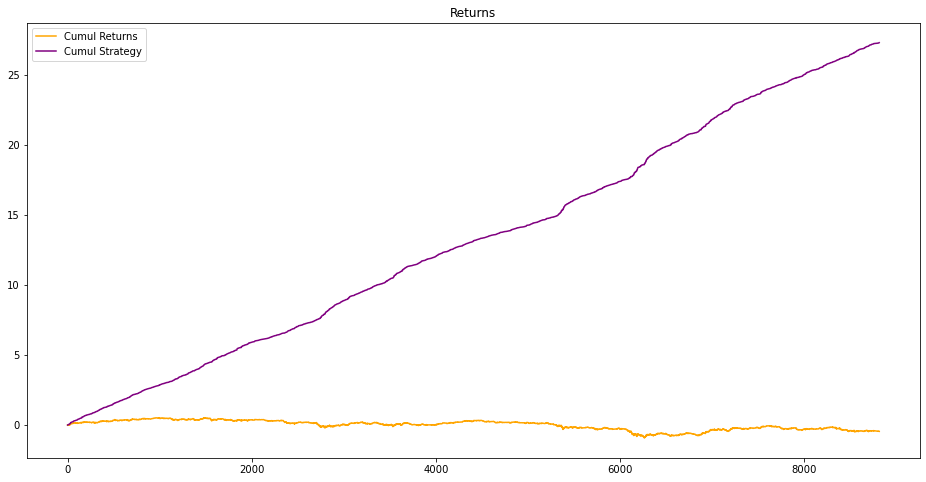

In [49]:
# Visualize the data
eth_df["Cumul Returns"].plot(
    kind='line',
    figsize=(16,8),
    title='Returns',
    color='orange',
    legend= 'ETH Returns'
)
eth_df["Cumul Strategy"].plot(
    kind='line',
    figsize=(16,8),
    color='purple',
    legend= 'Strat Returns'
)

In [50]:
#Print the returns
print('ETH gives a return of', eth_df["Cumul Returns"][8815]*100, '%')
print('The strategy gives a return of', eth_df["Cumul Strategy"][8815]*100, '%')


ETH gives a return of -43.69928290135974 %
The strategy gives a return of 2728.7251315449103 %
